# 주택 가격 예측 모델

## 1. 문제 정의 & 데이터 파악

### 1) 대회 목표(Problem)
- 주어진 주거 특성(79개 설명 변수)을 바탕으로 집의 최종 판매가 SalePrice를 예측하는 회귀 문제

### 2) 평가 지표(Metric)
- 예측값과 실제값의 로그에 대해 계산한 RMSE
- $RMSE$ ( $log(\hat{y}),\ log(y)$ ) 를 최소화하는 것이 목표
- 고가/저가의 상대적 오차를 동일 가중으로 반영하려는 의도라 로그를 취함

### 3) 데이터 구성(Data)
- 학습(train): 타깃 SalePrice 포함
- 테스트(test): 타깃 없음 (제출용)
- 특징(Features): Ames, Iowa 주택에 대한 약 79개 설명 변수(수치형+범주형)로 집의 각종 물리/품질/위치 속성을 포괄

### 4) 데이터 특성
- 결측치가 꽤 많고(차고/지하실/수영장 등), 범주형 변수가 비중이 큼
- 왜도(skew) 큰 수치 변수 존재 → log/Power 변환 고려
- 범주형은 원-핫 인코딩이 기본, 희소/희귀 카테고리는 묶어주면 안정적
- 누수 방지: 스케일링·인코딩 등 전처리는 train에만 fit → test에 transform(Pipeline/ColumnTransformer)

### 5) 기본 전략
- EDA
  - 결측치 지도/분포, SalePrice의 로그 분포 확인, 핵심 변수와의 관계 스냅샷
- 전처리
  - 도메인에 맞는 결측치 채움(예: 차고/지하실 없음 → "None"), 수치 중앙값 대체, 희귀 카테고리 통합
  - 수치 왜도 보정(PowerTransform/log), 파생 특성(TotalSF, TotalBaths, HouseAge, IsRemodeled..)
- 모델링 & 검증
  - 로그 타깃 기반 K-Fold CV 로 성능 비교
  - 선형 규제(Ridge/Lasso/ElasticNet) ↔ 트리 앙상블(GBR, XGB/LGBM) 비교
- 최종 제출
  - 최고 모델로 전체 재학습 → test 예측(log→원복) → submission.csv

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_squared_log_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [2]:
train = pd.read_csv("./modu-ds-5-house-prices-prediction/train.csv")
test  = pd.read_csv("./modu-ds-5-house-prices-prediction/test.csv")

X_train = train.drop(columns=["SalePrice"])
y = train["SalePrice"]
X_test = test

In [3]:
print(X_train.shape, X_test.shape, y.shape)
display(X_train.head())
display(y.head())

(1168, 80) (292, 80) (1168,)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2008,WD,Normal
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,3,2009,WD,Alloca
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal
3,239,20,RL,93.0,12030,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2007,New,Partial
4,891,50,RL,60.0,8064,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,2000,7,2007,WD,Normal


0    135000
1    179000
2    176000
3    318000
4    122900
Name: SalePrice, dtype: int64

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   MSZoning       1168 non-null   object 
 3   LotFrontage    950 non-null    float64
 4   LotArea        1168 non-null   int64  
 5   Street         1168 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1168 non-null   object 
 8   LandContour    1168 non-null   object 
 9   Utilities      1168 non-null   object 
 10  LotConfig      1168 non-null   object 
 11  LandSlope      1168 non-null   object 
 12  Neighborhood   1168 non-null   object 
 13  Condition1     1168 non-null   object 
 14  Condition2     1168 non-null   object 
 15  BldgType       1168 non-null   object 
 16  HouseStyle     1168 non-null   object 
 17  OverallQual    1168 non-null   int64  
 18  OverallC

---

## 2. 탐색적 데이터 분석 (EDA)

### 1) 결측치 탐색 (테이블 + 상위 변수 막대그래프)

,missing_rate
PoolQC,0.994863
MiscFeature,0.958904
Alley,0.940068
Fence,0.805651
MasVnrType,0.594178
FireplaceQu,0.466610
LotFrontage,0.186644
GarageCond,0.059075
GarageType,0.059075
GarageYrBlt,0.059075


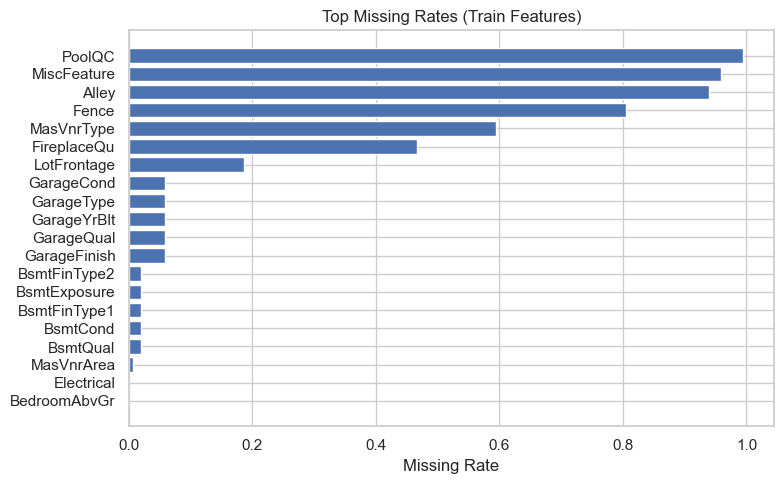

In [5]:
plt.rcParams["figure.figsize"] = (8,5)
sns.set(style="whitegrid")

missing_rate = X_train.isna().mean().sort_values(ascending=False)
display(missing_rate.to_frame("missing_rate").head(30))

topk = 20
mr_top = missing_rate.head(topk)[::-1]
plt.figure(figsize=(8, max(4, 0.25*len(mr_top))))
plt.barh(mr_top.index, mr_top.values)
plt.title("Top Missing Rates (Train Features)")
plt.xlabel("Missing Rate")
plt.tight_layout()
plt.show()

### 2) 타깃 분포 확인 (원 분포 vs 로그 변환)

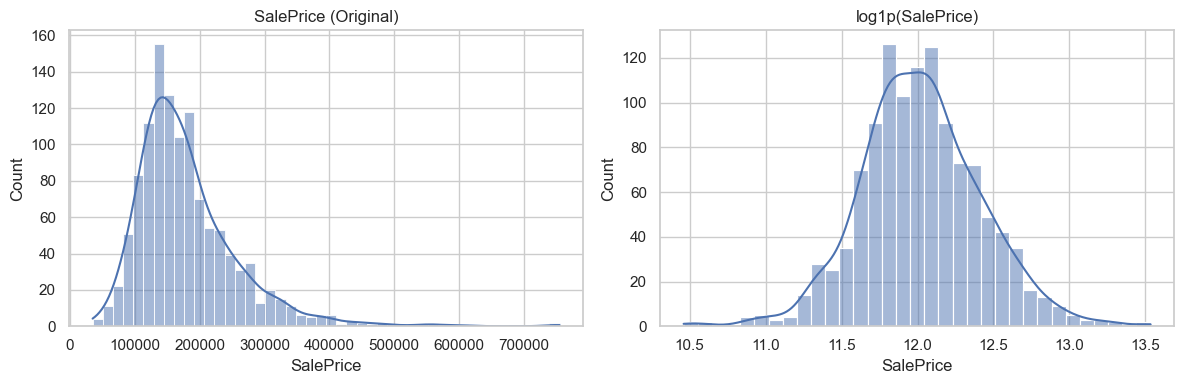

In [6]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(y, kde=True, ax=ax[0])
ax[0].set_title("SalePrice (Original)")

sns.histplot(np.log1p(y), kde=True, ax=ax[1])
ax[1].set_title("log1p(SalePrice)")

plt.tight_layout()
plt.show()

### 3) 수치형 상관관계 (log(SalePrice) 기준 Top-k)

logSalePrice    1.000000
OverallQual     0.811756
GrLivArea       0.700788
GarageCars      0.676538
GarageArea      0.648158
FullBath        0.611852
TotalBsmtSF     0.594687
1stFlrSF        0.588809
YearBuilt       0.566299
YearRemodAdd    0.564680
TotRmsAbvGrd    0.547517
GarageYrBlt     0.530576
Fireplaces      0.496071
Name: logSalePrice, dtype: float64

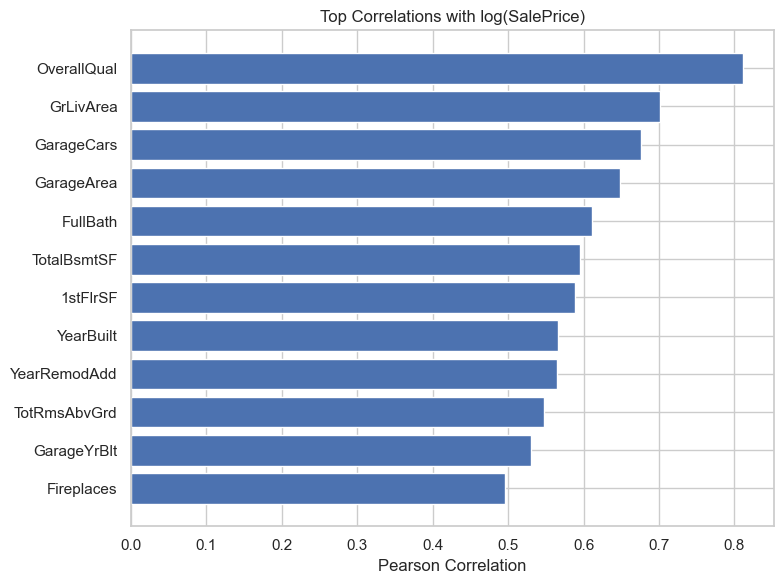

In [7]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

corr_df = pd.concat([X_train[num_cols], np.log1p(y).rename("logSalePrice")], axis=1)
corr = corr_df.corr(numeric_only=True)["logSalePrice"].dropna().sort_values(ascending=False)

topk = 12
top_features = corr.index[1:topk+1] 
display(corr.head(topk+1))

plt.figure(figsize=(8,6))
plt.barh(top_features[::-1], corr.loc[top_features][::-1].values)
plt.title("Top Correlations with log(SalePrice)")
plt.xlabel("Pearson Correlation")
plt.tight_layout()
plt.show()

### 4) 핵심 수치 변수 vs 타깃 산점 (로그 스케일)

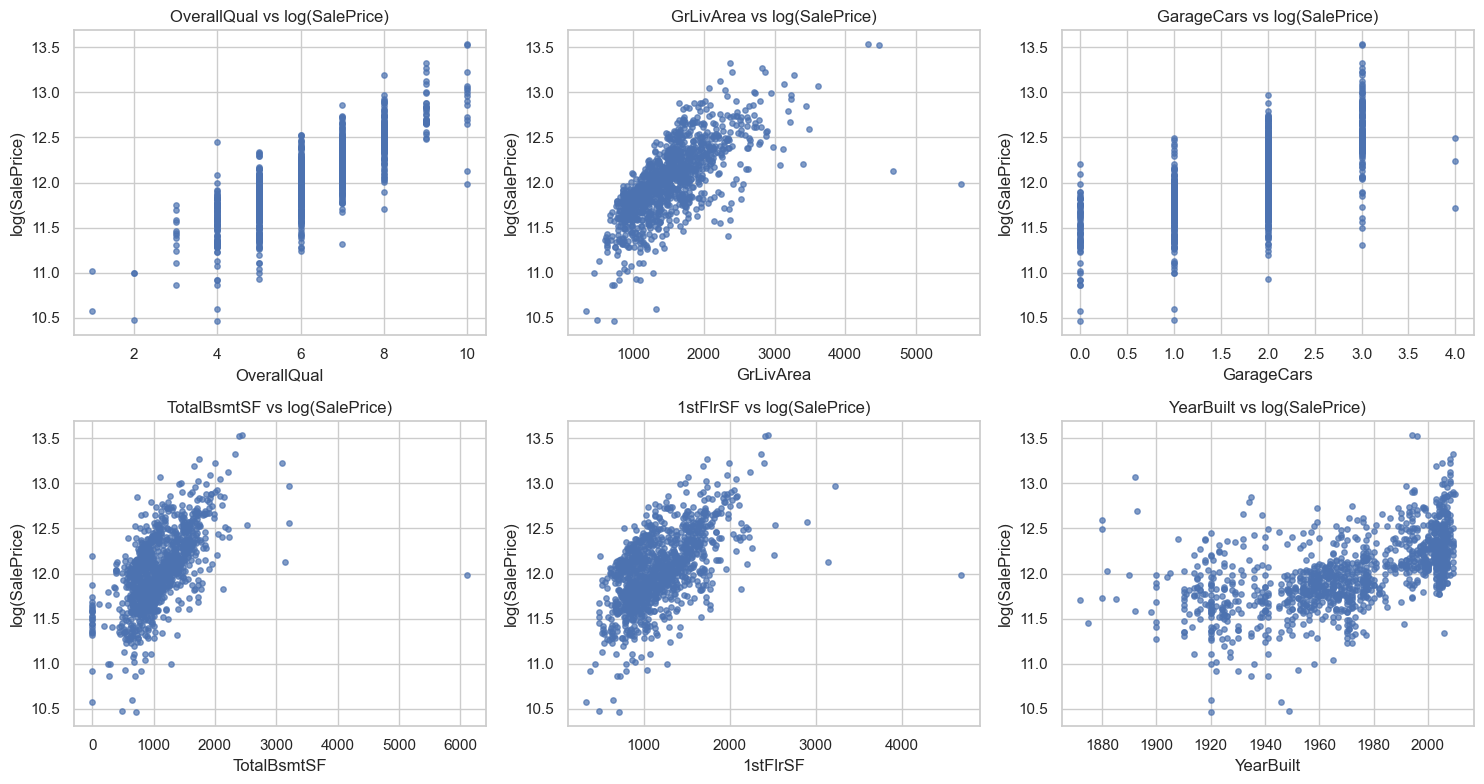

In [8]:
key_nums = ["OverallQual", "GrLivArea", "GarageCars", "TotalBsmtSF", "1stFlrSF", "YearBuilt"]
key_nums = [c for c in key_nums if c in X_train.columns]

logy = np.log1p(y)

n = len(key_nums)
cols = 3
rows = int(np.ceil(n/cols))
plt.figure(figsize=(5*cols, 4*rows))
for i, c in enumerate(key_nums, 1):
    plt.subplot(rows, cols, i)
    plt.scatter(X_train[c], logy, s=15, alpha=0.7)
    plt.title(f"{c} vs log(SalePrice)")
    plt.xlabel(c); plt.ylabel("log(SalePrice)")
plt.tight_layout()
plt.show()

### 5) 범주형 변수 영향 (Neighborhood, OverallQual 등)

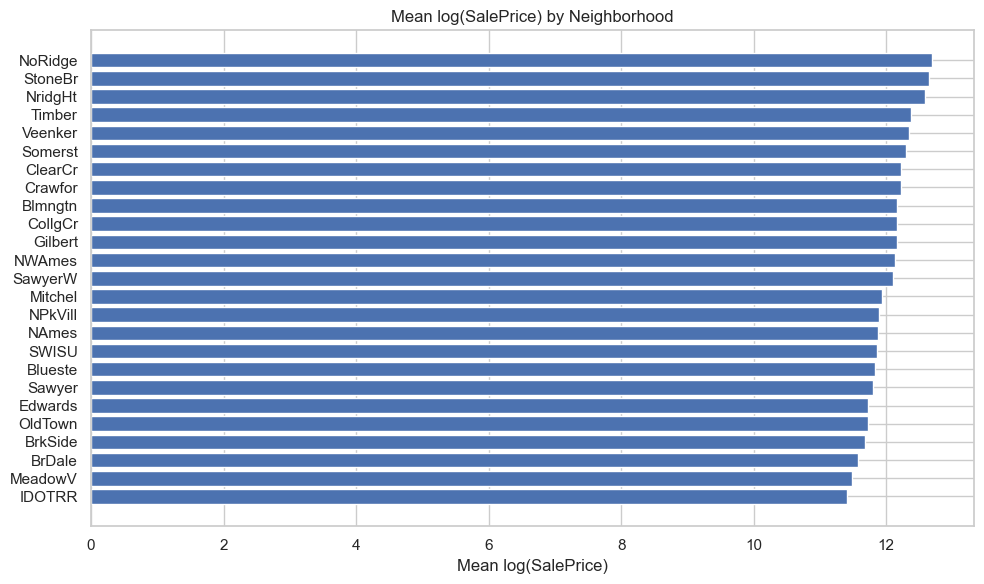

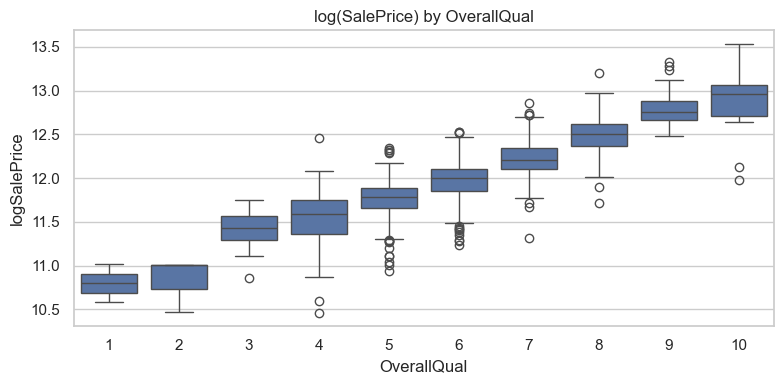

In [9]:
# Neighborhood별 평균 로그 가격
if "Neighborhood" in X_train.columns:
    tmp = pd.DataFrame({"Neighborhood": X_train["Neighborhood"],
                        "logSalePrice": np.log1p(y)})
    neigh_mean = tmp.groupby("Neighborhood")["logSalePrice"].mean().sort_values()
    plt.figure(figsize=(10,6))
    plt.barh(neigh_mean.index, neigh_mean.values)
    plt.title("Mean log(SalePrice) by Neighborhood")
    plt.xlabel("Mean log(SalePrice)")
    plt.tight_layout()
    plt.show()

# OverallQual(1~10) 박스플롯
if "OverallQual" in X_train.columns:
    df_box = pd.DataFrame({"OverallQual": X_train["OverallQual"], "logSalePrice": np.log1p(y)})
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df_box, x="OverallQual", y="logSalePrice")
    plt.title("log(SalePrice) by OverallQual")
    plt.tight_layout()
    plt.show()

### 6) 이상치 후보 탐지

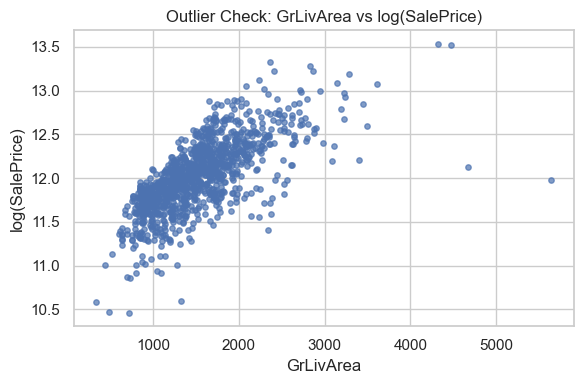

,Id,GrLivArea,SalePrice
256,1293,2372,107500
363,1063,2337,90000
643,667,2380,129000
1074,1350,2358,122000


In [10]:
if "GrLivArea" in X_train.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(X_train["GrLivArea"], np.log1p(y), s=15, alpha=0.7)
    plt.title("Outlier Check: GrLivArea vs log(SalePrice)")
    plt.xlabel("GrLivArea"); plt.ylabel("log(SalePrice)")
    plt.tight_layout()
    plt.show()

    thr_area = np.percentile(X_train["GrLivArea"], 93)  
    mask = (X_train["GrLivArea"]>=thr_area) & (np.log1p(y) < np.percentile(np.log1p(y), 30))
    display(train.loc[mask, ["Id","GrLivArea","SalePrice"]].head(10))

### 7) 변수 간 다중공선성 확인 

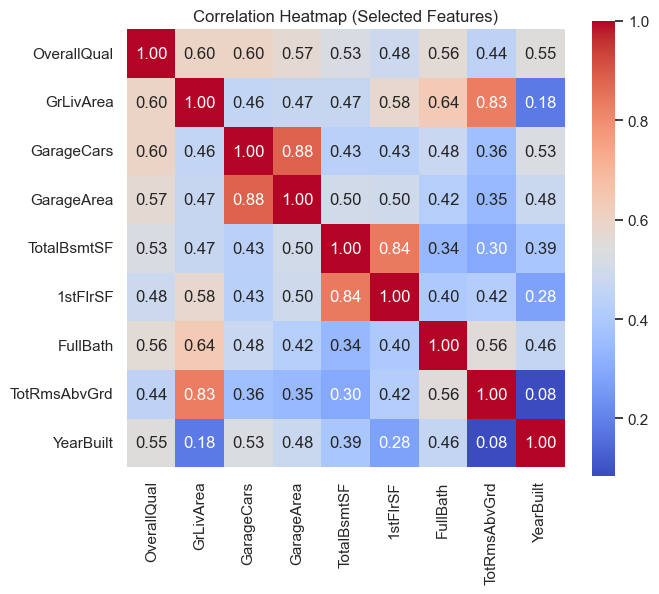

In [11]:
heat_vars = ["OverallQual","GrLivArea","GarageCars","GarageArea","TotalBsmtSF","1stFlrSF","FullBath","TotRmsAbvGrd","YearBuilt"]
heat_vars = [c for c in heat_vars if c in X_train.columns]
cm = X_train[heat_vars].corr()

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap (Selected Features)")
plt.tight_layout()
plt.show()

---

## 3. 데이터 전처리

### 1) 결측치 처리 전략
- 의미 있는 결측 → 없음(None)
  - Alley, PoolQC, Fence, FireplaceQu, GarageType, BsmtQual 등
  - 값이 비어있다는 것은 "해당 시설 자체가 없음"을 의미하므로 "None"으로 채움
- 진짜 결측 → 수치형은 중앙값/범주형은 최빈값
  - 예: LotFrontage (각 집의 도로와의 거리) → 같은 Neighborhood의 중앙값으로 채우는 방식 사용
- 그 외 수치형은 median, 범주형은 mode로 채움

In [12]:
none_fill = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2",
             "FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond",
             "PoolQC","Fence","MiscFeature","MasVnrType"]

for c in none_fill:
    if c in X_train.columns:
        X_train[c] = X_train[c].fillna("None")
        X_test[c] = X_test[c].fillna("None")

In [13]:
if {"Neighborhood","LotFrontage"}.issubset(X_train.columns):
    neigh_med  = X_train.groupby("Neighborhood")["LotFrontage"].median()
    global_med = X_train["LotFrontage"].median()
    X_train["LotFrontage"] = X_train["LotFrontage"].fillna(X_train["Neighborhood"].map(neigh_med)).fillna(global_med)
    X_test["LotFrontage"] = X_test["LotFrontage"].fillna(X_test["Neighborhood"].map(neigh_med)).fillna(global_med)
    
for c in ["MSSubClass","MoSold"]:
    if c in X_train.columns:
        X_train[c] = X_train[c].astype(str)
        X_test[c] = X_test[c].astype(str)

### 2) 파생 변수 생성 (Feature Engineering)

In [14]:
for df in (X_train, X_test):
    df["TotalSF"] = df.get("TotalBsmtSF",0) + df.get("1stFlrSF",0) + df.get("2ndFlrSF",0)
    df["TotalBaths"] = df.get("FullBath",0) + 0.5*df.get("HalfBath",0) + df.get("BsmtFullBath",0) + 0.5*df.get("BsmtHalfBath",0)
    df["HouseAge"] = df.get("YrSold",0) - df.get("YearBuilt",0)
    df["RemodAge"] = df.get("YrSold",0) - df.get("YearRemodAdd",0)
    df["IsRemodeled"] = (df.get("YearRemodAdd",0) != df.get("YearBuilt",0)).astype(int)
    df["HasGarage"] = (df.get("GarageArea",0).fillna(0) > 0).astype(int)
    df["HasBsmt"] = (df.get("TotalBsmtSF",0).fillna(0) > 0).astype(int)
    df["Qual_x_TotalSF"] = df.get("OverallQual",0) * df["TotalSF"]

### 3) 희귀 카테고리 묶기 (train 빈도 기준)

In [15]:
cat_cols_tmp = X_train.select_dtypes(exclude=[np.number]).columns

for c in cat_cols_tmp:
    freq = X_train[c].value_counts(normalize=True)
    rare = freq[freq < 0.01].index
    if len(rare):
        X_train[c] = X_train[c].replace(rare, "Rare")
        X_test[c] = X_test[c].replace(rare, "Rare")

### 4. ColumnTransformer 구성 + fit/transform

In [16]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_pipe = Pipeline([("impute", SimpleImputer(strategy="median")),
                         ("power", PowerTransformer(method="yeo-johnson", standardize=True))])

categorical_pipe = Pipeline([("impute", SimpleImputer(strategy="most_frequent")),
                             ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preprocess = ColumnTransformer([("num", numeric_pipe, num_cols),
                                ("cat", categorical_pipe, cat_cols)])

---

## 4. 모델링 준비
### 1) 교차검증 셋업 + 평가 지표(RMSE on log)

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

def rmse_log(y_true, y_pred):
    y_pred = np.maximum(y_pred, 0.0)
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))

### 2) 베이스라인 파이프라인

In [18]:
candidates = {"Linear": LinearRegression(),
              "Ridge": Ridge(alpha=5.0),
              "Lasso": Lasso(alpha=1e-3, max_iter=20000),
              "ElasticNet": ElasticNet(alpha=5e-3, l1_ratio=0.3, max_iter=20000),
              "RandomForest": RandomForestRegressor(n_estimators=600, random_state=42, n_jobs=-1),
              "GradientBoosting": GradientBoostingRegressor(n_estimators=1500, learning_rate=0.02, max_depth=3, random_state=42)}

### 3) 교차검증으로 베이스라인 성능 확인

In [ ]:
rows = []
for name, base_model in candidates.items():
    fold_scores = []
    pipe = Pipeline([("pre", preprocess), ("model", base_model)])

    for tr_idx, va_idx in cv.split(X_train):
        X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

        pipe.fit(X_tr, y_tr)           
        y_pred = pipe.predict(X_va)
        fold_scores.append(rmse_log(y_va, y_pred))

    rows.append([name, np.mean(fold_scores), np.std(fold_scores)])
    
cv_table = pd.DataFrame(rows, columns=["Model","CV_RMSE_log","Std"]).sort_values("CV_RMSE_log")
display(cv_table)

,Model,CV_RMSE_log,Std
5,GradientBoosting,0.130209,0.006590
4,RandomForest,0.149418,0.017798
2,Lasso,0.354194,0.192621
1,Ridge,0.554449,0.348283
3,ElasticNet,0.557043,0.346527
0,Linear,1.248087,0.681088


---

## 5. 성능 개선

### 1) 하이퍼파라미터 튜닝( Grid / Randomized )

In [ ]:
def _rmsle(y_true, y_pred):
    y_pred = np.asarray(y_pred, dtype=float)
    y_pred = np.nan_to_num(y_pred, nan=0.0, posinf=0.0, neginf=0.0)
    y_pred = np.clip(y_pred, 0.0, np.percentile(y_true, 99.9)*5)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(_rmsle, greater_is_better=False)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

ridge_pipe = Pipeline([("pre", preprocess), ("model", Ridge())])
lasso_pipe = Pipeline([("pre", preprocess), ("model", Lasso(max_iter=20000))])
enet_pipe  = Pipeline([("pre", preprocess), ("model", ElasticNet(max_iter=20000))])

rf_pipe  = Pipeline([("pre", preprocess), ("model", RandomForestRegressor(random_state=42, n_jobs=-1))])
gbr_pipe = Pipeline([("pre", preprocess), ("model", GradientBoostingRegressor(random_state=42))])


ridge_grid = {"model__alpha": np.logspace(-3, 3, 13)}                        
lasso_grid = {"model__alpha": np.logspace(-4, -1, 16)}                       
enet_grid  = {"model__alpha": np.logspace(-4, -1, 12), "model__l1_ratio": [0.1,0.3,0.5,0.7,0.9]}

rf_dist = {"model__n_estimators": np.arange(300, 1201, 100),
           "model__max_depth": [None, 6, 10, 14, 18, 22, 26], 
           "model__min_samples_split": [2, 5, 10],
           "model__min_samples_leaf": [1, 2, 4],
           "model__max_features": ["sqrt", 0.3, 0.5, 0.7]}

gbr_dist = {"model__n_estimators": np.arange(500, 3001, 250),
            "model__learning_rate": np.linspace(0.01, 0.1, 10),
            "model__max_depth": [2, 3, 4, 5],
            "model__subsample":  np.linspace(0.6, 1.0, 5),
            "model__max_features": ["sqrt", None]}


ridge_gs = GridSearchCV(ridge_pipe, ridge_grid, scoring=rmsle_scorer, cv=cv, n_jobs=-1, verbose=0)
lasso_gs = GridSearchCV(lasso_pipe, lasso_grid, scoring=rmsle_scorer, cv=cv, n_jobs=-1, verbose=0)
enet_gs  = GridSearchCV(enet_pipe,  enet_grid,  scoring=rmsle_scorer, cv=cv, n_jobs=-1, verbose=0)

rf_rs  = RandomizedSearchCV(rf_pipe,  rf_dist,  n_iter=40, scoring=rmsle_scorer, cv=cv, n_jobs=-1, random_state=42, verbose=0)
gbr_rs = RandomizedSearchCV(gbr_pipe, gbr_dist, n_iter=40, scoring=rmsle_scorer, cv=cv, n_jobs=-1, random_state=42, verbose=0)

ridge_gs.fit(X_train, y)
lasso_gs.fit(X_train, y)
enet_gs.fit(X_train, y)
rf_rs.fit(X_train, y)
gbr_rs.fit(X_train, y)


summary = pd.DataFrame([["Ridge (GS)", -ridge_gs.best_score_, ridge_gs.best_params_],
                        ["Lasso (GS)", -lasso_gs.best_score_, lasso_gs.best_params_],
                        ["ElasticNet (GS)", -enet_gs.best_score_, enet_gs.best_params_],
                        ["RandomForest (RS)", -rf_rs.best_score_, rf_rs.best_params_],
                        ["GradBoosting (RS)", -gbr_rs.best_score_, gbr_rs.best_params_]
                       ],columns=["Model", "CV RMSLE (lower=better)", "Best Params"]).sort_values("CV RMSLE (lower=better)")
display(summary)

,Model,CV RMSLE (lower=better),Best Params
4,GradBoosting (RS),0.127069,"{'model__subsample': 0.7, 'model__n_estimators..."
3,RandomForest (RS),0.145518,"{'model__n_estimators': 900, 'model__min_sampl..."
0,Ridge (GS),0.276797,{'model__alpha': 1000.0}
1,Lasso (GS),0.352779,{'model__alpha': 0.1}
2,ElasticNet (GS),0.434192,"{'model__alpha': 0.0001, 'model__l1_ratio': 0.9}"


### 최상 모델 전체 학습 → 테스트 예측

In [21]:
best_name, best_score = summary.iloc[0]["Model"], summary.iloc[0]["CV RMSLE (lower=better)"]
print(f"Best by CV: {best_name}  |  CV RMSLE={best_score:.5f}")

best_est = {"Ridge (GS)": ridge_gs.best_estimator_,
            "Lasso (GS)": lasso_gs.best_estimator_,
            "ElasticNet (GS)": enet_gs.best_estimator_,
            "RandomForest (RS)": rf_rs.best_estimator_,
            "GradBoosting (RS)": gbr_rs.best_estimator_,}[best_name]

best_est.fit(X_train, y)
pred_test = best_est.predict(X_test)
pred_test = np.clip(pred_test, 0.0, np.percentile(y, 99.9)*5)

submission = pd.DataFrame({"Id": X_test["Id"], "SalePrice": pred_test})
submission.to_csv("submission_tuned.csv", index=False)
submission.head()

Best by CV: GradBoosting (RS)  |  CV RMSLE=0.12707


,Id,SalePrice
0,86,266748.110311
1,227,278835.780071
2,492,149275.383014
3,64,132185.507696
4,576,107594.896510


### 2) LightGBM / XGBoost / CatBoost 후보 추가

In [22]:
candidates_ext = {}
errors = {}

# LightGBM 
try:
    from lightgbm import LGBMRegressor
    lgbm_pipe = Pipeline([("pre", preprocess),
                          ("model", LGBMRegressor(n_estimators=3000, learning_rate=0.02, num_leaves=31,
                                                  subsample=0.7, colsample_bytree=0.7, random_state=42))])

    lgbm_dist = {"model__n_estimators": [2000, 3000, 4000, 6000, 8000],
                 "model__learning_rate": np.linspace(0.01, 0.05, 5),
                 "model__num_leaves": [15, 31, 63, 127],
                 "model__subsample": np.linspace(0.6, 1.0, 5),
                 "model__colsample_bytree": np.linspace(0.6, 1.0, 5),
                 "model__reg_alpha": [0.0, 0.001, 0.01, 0.1],
                 "model__reg_lambda": [0.1, 1, 5, 10]}

    lgbm_rs = RandomizedSearchCV(lgbm_pipe, lgbm_dist, n_iter=40, scoring=rmsle_scorer,
                                 cv=cv, n_jobs=-1, random_state=42, verbose=0)
    lgbm_rs.fit(X_train, y)
    candidates_ext["LightGBM (RS)"] = (-lgbm_rs.best_score_, lgbm_rs.best_params_, lgbm_rs.best_estimator_)

except Exception as e:
    errors["LightGBM"] = e


# XGBoost 
try:
    from xgboost import XGBRegressor
    xgb_pipe = Pipeline([("pre", preprocess),
                         ("model", XGBRegressor(n_estimators=3000, learning_rate=0.02, max_depth=4,
                                                subsample=0.7, colsample_bytree=0.7,
                                                reg_alpha=1e-3, reg_lambda=1.0, min_child_weight=1,
                                                random_state=42, tree_method="hist"))])

    xgb_dist = {"model__n_estimators": [1500, 2500, 3000, 4000],
                "model__learning_rate": np.linspace(0.01, 0.05, 5),
                "model__max_depth": [3, 4, 5, 6],
                "model__subsample": np.linspace(0.6, 1.0, 5),
                "model__colsample_bytree": np.linspace(0.6, 1.0, 5),
                "model__reg_alpha": [0.0, 1e-3, 1e-2, 0.1],
                "model__reg_lambda": [0.1, 1, 5, 10],
                "model__min_child_weight": [1, 5, 10]}

    xgb_rs = RandomizedSearchCV(xgb_pipe, xgb_dist, n_iter=40, scoring=rmsle_scorer,
                                cv=cv, n_jobs=-1, random_state=42, verbose=0)
    xgb_rs.fit(X_train, y)
    candidates_ext["XGBoost (RS)"] = (-xgb_rs.best_score_, xgb_rs.best_params_, xgb_rs.best_estimator_)

except Exception as e:
    errors["XGBoost"] = e


#  CatBoost 
try:
    from catboost import CatBoostRegressor
    cb_pipe = Pipeline([("pre", preprocess),
                        ("model", CatBoostRegressor(iterations=3000, learning_rate=0.03, depth=8,
                                                    l2_leaf_reg=3.0, subsample=0.8, loss_function="RMSE", 
                                                    random_state=42, verbose=0))])

    cb_dist = {"model__iterations": [2000, 3000, 5000, 7000],
               "model__learning_rate": np.linspace(0.02, 0.08, 4),
               "model__depth": [6, 8, 10],
               "model__l2_leaf_reg": [1, 3, 5, 7],
               "model__subsample": [0.6, 0.8, 1.0]}

    cb_rs = RandomizedSearchCV(cb_pipe, cb_dist, n_iter=40, scoring=rmsle_scorer,
                               cv=cv, n_jobs=-1, random_state=42, verbose=0)
    cb_rs.fit(X_train, y)
    candidates_ext["CatBoost (RS)"] = (-cb_rs.best_score_, cb_rs.best_params_, cb_rs.best_estimator_)

except Exception as e:
    errors["CatBoost"] = e


# 결과 요약 
summary_ext = pd.DataFrame([[k, v[0], v[1]] for k, v in candidates_ext.items()], 
                           columns=["Model", "CV RMSLE (lower=better)", "Best Params"]).sort_values("CV RMSLE (lower=better)")

display(summary_ext)

if errors:
    print("\n[Skipped models]")
    for k, e in errors.items():
        print(f"- {k}: {e}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4201
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 229
[LightGBM] [Info] Start training from score 180194.401541


,Model,CV RMSLE (lower=better),Best Params
2,CatBoost (RS),0.127948,"{'model__subsample': 1.0, 'model__learning_rat..."
1,XGBoost (RS),0.131838,"{'model__subsample': 0.9, 'model__reg_lambda':..."
0,LightGBM (RS),0.139751,"{'model__subsample': 0.7, 'model__reg_lambda':..."


### 3) 상위 모델로 블렌딩

In [23]:
best_keys = summary_ext["Model"].head(3).tolist()
best_ests = [candidates_ext[k][2] for k in best_keys] 
for est in best_ests:
    est.fit(X_train, y)

preds = np.vstack([est.predict(X_test) for est in best_ests])
weights = np.array([0.5, 0.3, 0.2])[:len(best_ests)]
blend = np.average(preds, axis=0, weights=weights)
blend = np.clip(blend, 0.0, np.percentile(y, 99.9)*5)

submission_blend = pd.DataFrame({"Id": X_test["Id"], "SalePrice": blend})
submission_blend.to_csv("submission_blend_ext.csv", index=False)
submission_blend.head()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4201
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 229
[LightGBM] [Info] Start training from score 180194.401541


,Id,SalePrice
0,86,260352.508665
1,227,269842.939962
2,492,151990.694398
3,64,131599.722294
4,576,114935.368612


### 4) CV 기반 가중치 최적화 블렌딩 (RMSLE 최소화)
- 각 모델을 K-Fold로 OOF 예측 → 훈련 표본 각각에 대해 “자기를 보지 않은” 예측을 얻음 ⇒ 가중치 최적화 시 과적합 방지
- 테스트는 fold별 예측을 평균 → 분산 감소(각 fold모델의 앙상블 효과)
- 가중치는 [0,1], 합=1 제약 하에 RMSLE 최소화 → 해석 쉬운 비음수 가중 평균
- 예측 클리핑(≥0, 상한) → RMSLE 정의역 보장 + 폭주값 완화

In [24]:
from sklearn.base import clone
from scipy.optimize import minimize

def rmsle(y_true, y_pred):
    yt = np.asarray(y_true).astype(float)
    yp = np.asarray(y_pred).astype(float)
    yt = np.maximum(yt, 0.0)
    yp = np.maximum(yp, 0.0)
    return np.sqrt(np.mean((np.log1p(yp) - np.log1p(yt))**2))

def get_oof_and_test_preds(estimators, X, y, X_test, n_splits=5, seed=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof_preds = [np.zeros(len(y), dtype=float) for _ in estimators]
    test_preds = [np.zeros(len(X_test), dtype=float) for _ in estimators]

    for i, est in enumerate(estimators):
        fold_test_preds = []
        for tr_idx, va_idx in kf.split(X):
            est_i = clone(est)
            est_i.fit(X.iloc[tr_idx], y.iloc[tr_idx])
            oof_preds[i][va_idx] = est_i.predict(X.iloc[va_idx])
            fold_test_preds.append(est_i.predict(X_test))
        test_preds[i] = np.mean(np.vstack(fold_test_preds), axis=0)
    return np.vstack(oof_preds), np.vstack(test_preds)

def find_best_weights(oof_preds, y_true):
    m = oof_preds.shape[0]
    x0 = np.ones(m) / m
    bounds = [(0.0, 1.0)] * m
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
    def _loss(w):
        pred = np.average(oof_preds, axis=0, weights=w)
        return rmsle(y_true, pred)
    res = minimize(_loss, x0=x0, bounds=bounds, constraints=cons, method="SLSQP", options={"maxiter": 100})
    return res.x


oof_preds, test_preds = get_oof_and_test_preds(best_ests, X_train, y, X_test, n_splits=5, seed=42)
opt_weights = find_best_weights(oof_preds, y)
print("Optimized weights:", np.round(opt_weights, 4))

blend_opt = np.average(test_preds, axis=0, weights=opt_weights)
hi_cap = np.percentile(y, 99.9) * 5
blend_opt = np.clip(blend_opt, 0.0, hi_cap)

submission_blend_opt = pd.DataFrame({"Id": X_test["Id"], "SalePrice": blend_opt})
submission_blend_opt.to_csv("submission_blend_opt.csv", index=False)
submission_blend_opt.head()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3942
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 216
[LightGBM] [Info] Start training from score 178344.738758
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3952
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 206
[LightGBM] [Info] Start training from score 179651.716274
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3952
[LightGBM] [Info] Number of data points in the train set: 934, number of used features: 206
[LightGBM] [Info] St

,Id,SalePrice
0,86,270647.480703
1,227,272929.633175
2,492,146954.244437
3,64,136411.492633
4,576,114831.145208


### 5) 스태킹(Stacking)
- K-겹으로 각 기저 모델의 OOF 예측
- 그 OOF 예측을 메타 학습 데이터로 써서 RidgeCV 학습
- 마지막에 기저 모델들을 전체 train으로 재학습한 뒤 test에서 예측 → 메타에 넣어 최종 예측

In [25]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV, ElasticNetCV

meta = RidgeCV(alphas=np.logspace(-3, 3, 13))
estimators = [(f"m{i}", est) for i, est in enumerate(best_ests)]

stack = StackingRegressor(estimators=estimators, final_estimator=meta, passthrough=False, n_jobs=-1)

stack.fit(X_train, y)
pred_stack = stack.predict(X_test)

hi_cap = np.percentile(y, 99.9) * 5
pred_stack = np.clip(pred_stack, 0.0, hi_cap)

submission_stack = pd.DataFrame({"Id": X_test["Id"], "SalePrice": pred_stack})
submission_stack.to_csv("submission_stack.csv", index=False)
submission_stack.head()

,Id,SalePrice
0,86,261532.530217
1,227,270788.695993
2,492,153007.626033
3,64,130640.175012
4,576,114945.910060


### 6) Rank Averaging 블렌딩
- 앙상블 트릭 (Rank Averaging + Quantile Mapping)
- 모델들이 ‘누가 더 비싼지’에 대한 순위 합의를 만든 뒤, 그 순위를 타깃 분포(scale)로 다시 매핑

In [26]:
def rank_average_to_y_quantile(preds_matrix, y_ref):
    ranks = np.apply_along_axis(lambda x: pd.Series(x).rank(method="average").values, 1, preds_matrix)
    avg_rank = ranks.mean(axis=0)
    perc = (avg_rank - 1) / (len(avg_rank) - 1 + 1e-9)  
    return np.quantile(y_ref, perc)

rank_blend = rank_average_to_y_quantile(test_preds, y)  
rank_blend = np.clip(rank_blend, 0.0, np.percentile(y, 99.9)*5)
pd.DataFrame({"Id": X_test["Id"], "SalePrice": rank_blend}).to_csv("submission_rankavg.csv", index=False)

### 7-1) 로그 타깃 학습 (log1p / expm1) 

In [27]:
from sklearn.compose import TransformedTargetRegressor

log_best_ests = [TransformedTargetRegressor(regressor=est, func=np.log1p, inverse_func=np.expm1) for est in best_ests]

for est in log_best_ests:
    est.fit(X_train, y)

preds = np.vstack([est.predict(X_test) for est in log_best_ests])
weights = np.array([0.5, 0.3, 0.2])[:len(log_best_ests)]
blend = np.average(preds, axis=0, weights=weights)

hi_cap = np.percentile(y, 99.9) * 5
blend = np.clip(blend, 0.0, hi_cap)

submission_log_blend = pd.DataFrame({"Id": X_test["Id"], "SalePrice": blend})
submission_log_blend.to_csv("submission_log_blend.csv", index=False)
submission_log_blend.head()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4201
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 229
[LightGBM] [Info] Start training from score 12.020568


,Id,SalePrice
0,86,257400.871755
1,227,264166.714918
2,492,145231.159482
3,64,127779.558427
4,576,113389.727811


### 7-2) 로그 타깃 학습 (log1p / expm1) 
- Successive Halving + 로그 타깃 학습
- RandomizedSearchCV → HalvingRandomSearchCV
  - 처음엔 많은 후보를 작은 budget(트리 수 적음)으로 평가   
    → 점수 낮은 후보 조기 탈락    
    → 살아남은 것만 더 큰 budget(트리 수 증가) 으로 재평가

In [28]:
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingRandomSearchCV, KFold
from lightgbm import LGBMRegressor

cv = KFold(n_splits=5, shuffle=True, random_state=42)

lgbm_pipe = Pipeline([("pre", preprocess),
                      ("model", LGBMRegressor(n_estimators=2000, learning_rate=0.03, num_leaves=31, subsample=0.8, colsample_bytree=0.8, 
                                              reg_alpha=0.0, reg_lambda=1.0, random_state=42, n_jobs=-1))])

lgbm_ttr = TransformedTargetRegressor(regressor=lgbm_pipe, func=np.log1p, inverse_func=np.expm1)

lgbm_dist = {"regressor__model__learning_rate": np.linspace(0.02, 0.06, 5),
             "regressor__model__num_leaves": [15, 31, 63, 127],
             "regressor__model__subsample": np.linspace(0.6, 1.0, 5),
             "regressor__model__colsample_bytree": np.linspace(0.6, 1.0, 5),
             "regressor__model__reg_alpha": [0.0, 0.001, 0.01, 0.1],
             "regressor__model__reg_lambda": [0.1, 1.0, 5.0, 10.0],}

lgbm_sh = HalvingRandomSearchCV(estimator=lgbm_ttr, param_distributions=lgbm_dist, resource="regressor__model__n_estimators",   
                                min_resources=200, max_resources=4000, factor=3, aggressive_elimination=True, scoring=rmsle_scorer,
                                cv=cv, n_jobs=-1, random_state=42, verbose=0)

lgbm_sh.fit(X_train, y)
print(lgbm_sh.best_params_, -lgbm_sh.best_score_)

pred_test_lgbm_log = lgbm_sh.best_estimator_.predict(X_test)
hi_cap = np.percentile(y, 99.9) * 5
pred_test_lgbm_log = np.clip(pred_test_lgbm_log, 0.0, hi_cap)

pd.DataFrame({"Id": X_test["Id"], "SalePrice": pred_test_lgbm_log}).to_csv("submission_lgbm_log.csv", index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4201
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 229
[LightGBM] [Info] Start training from score 12.020568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
{'regressor__model__subsample': 0.6, 'regressor__model__reg_lambda': 0.1, 'regressor__model__reg_alpha': 0.1, 'regressor__model__num_leaves': 63, 'regressor__model__learning_rate': 0.039999999999999994, 'regressor__model__colsample_bytree': 0.6, 'regressor__model__n_estimators': 1800} 0.1384336816606035


### 7-3) 로그 타깃 학습 (log1p / expm1) 
- 스태킹(RidgeCV) + 타깃 로그 학습

In [29]:
estimators = [(f"m{i}", est) for i, est in enumerate(best_ests)]
meta = RidgeCV(alphas=np.logspace(-3, 3, 13))
stack = StackingRegressor(estimators=estimators, final_estimator=meta, passthrough=False, n_jobs=-1)
stack_log = TransformedTargetRegressor(regressor=stack, func=np.log1p, inverse_func=np.expm1)

stack_log.fit(X_train, y)
pred_stack_log = stack_log.predict(X_test)

hi_cap = np.percentile(y, 99.9) * 5
pred_stack_log = np.clip(pred_stack_log, 0.0, hi_cap)

pd.DataFrame({"Id": X_test["Id"], "SalePrice": pred_stack_log}).to_csv("submission_stack_log.csv", index=False)

---

## 추가 실험

### 1) 기하평균 블렌딩(geom-mean)

In [30]:
preds = np.vstack([est.predict(X_test) for est in best_ests])
weights = np.array([0.5, 0.3, 0.2])[:preds.shape[0]]

eps = 1e-9
gblend = np.exp(np.average(np.log(np.clip(preds, eps, None)), axis=0, weights=weights))

hi = np.percentile(y, 99.9) * 5
gblend = np.clip(gblend, 0.0, hi)
pd.DataFrame({"Id": X_test["Id"], "SalePrice": gblend}).to_csv("submission_geom_blend.csv", index=False)

### 2) 그룹 보존 CV (GroupKFold)

In [31]:
from sklearn.model_selection import GroupKFold

groups = X_train["Neighborhood"]  
gkf = GroupKFold(n_splits=5)

lgbm_sh.set_params(cv=gkf)
lgbm_sh.fit(X_train, y, groups=groups)
pred = lgbm_sh.best_estimator_.predict(X_test)
pd.DataFrame({"Id": X_test["Id"], "SalePrice": pred}).to_csv("sub_groupkfold.csv", index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4201
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 229
[LightGBM] [Info] Start training from score 12.020568


### 3) 네이티브 CatBoost(원핫 대신 cat_features) — 범주 처리 강화

In [32]:
from catboost import CatBoostRegressor

cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
Xtr_cb = X_train.copy(); Xte_cb = X_test.copy()
for c in cat_cols: 
    Xtr_cb[c] = Xtr_cb[c].astype(str)
    Xte_cb[c] = Xte_cb[c].astype(str)
cat_idx = [Xtr_cb.columns.get_loc(c) for c in cat_cols]

cb = CatBoostRegressor(iterations=4000, learning_rate=0.04, depth=8, l2_leaf_reg=3.0, subsample=0.8, 
                       loss_function="RMSE", random_state=42, verbose=0, thread_count=-1)

cb.fit(Xtr_cb, y, cat_features=cat_idx)
pred_cb = cb.predict(Xte_cb)

hi = np.percentile(y, 99.9) * 5
pred_cb = np.clip(pred_cb, 0.0, hi)
pd.DataFrame({"Id": X_test["Id"], "SalePrice": pred_cb}).to_csv("submission_catboost_native.csv", index=False)

### 4) OOF 타깃 인코딩(고카디널리티 범주 강화)

In [33]:
def oof_target_mean_encode(train, test, y, col, n_splits=5, seed=42, noise=0.0):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    oof = pd.Series(index=train.index, dtype=float)
    global_mean = y.mean()
    for tr_idx, va_idx in kf.split(train):
        means = y.iloc[tr_idx].groupby(train.iloc[tr_idx][col]).mean()
        oof.iloc[va_idx] = train.iloc[va_idx][col].map(means).fillna(global_mean)
    test_enc = test[col].map(y.groupby(train[col]).mean()).fillna(global_mean)
    if noise > 0: 
        oof += np.random.normal(0, noise, size=len(oof))
    return oof, test_enc

high_card = ["Neighborhood", "Exterior1st", "Exterior2nd"]  
X_tr_enc, X_te_enc = X_train.copy(), X_test.copy()
for c in high_card:
    tr, te = oof_target_mean_encode(X_train, X_test, y, c, n_splits=5, noise=0.001)
    X_tr_enc[f"{c}_te"] = tr
    X_te_enc[f"{c}_te"] = te

best = clone(lgbm_sh.best_estimator_)  
best.fit(X_tr_enc, y)
pred_te = best.predict(X_te_enc)
pd.DataFrame({"Id": X_test["Id"], "SalePrice": pred_te}).to_csv("submission_te.csv", index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4201
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 229
[LightGBM] [Info] Start training from score 12.020568


### 5) 의도적 아웃라이어 완화 — 윈저라이즈 + 강건 학습

In [34]:
def winsorize_series(s, q=0.005):
    lo, hi = s.quantile(q), s.quantile(1-q)
    return s.clip(lo, hi)

X_w = X_train.copy()
num_cols = X_w.select_dtypes(include=[np.number]).columns
X_w[num_cols] = X_w[num_cols].apply(winsorize_series, q=0.005)  

best = clone(lgbm_sh.best_estimator_)
best.fit(X_w, y)
pred = best.predict(X_test)
pd.DataFrame({"Id": X_test["Id"], "SalePrice": np.clip(pred, 0, np.percentile(y,99.9)*5)}).to_csv("submission_winsor.csv", index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4171
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 229
[LightGBM] [Info] Start training from score 12.020568


### 6) 소프트 Pseudo-Labeling — 테스트 예측을 약가중치로 재학습

In [35]:
best = clone(lgbm_sh.best_estimator_) 

pseudo_y = pd.Series(pred_test_lgbm_log, index=X_test.index)
X_aug = pd.concat([X_train, X_test], axis=0)
y_aug = pd.concat([y, pseudo_y], axis=0)

w = np.concatenate([np.ones(len(y)), np.full(len(X_test), 0.1)]) 
best.fit(X_aug, y_aug, model__sample_weight=w)  
pred_pl = best.predict(X_test)

pd.DataFrame({"Id": X_test["Id"], "SalePrice": pred_pl}).to_csv("submission_pseudolabel.csv", index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4484
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 241
[LightGBM] [Info] Start training from score 12.020535
